# Geodemographical Segmentation - Model Testing

This notebook implements a Self‐Organizing Map (SOM)–based approach for geodemographic segmentation using MiniSom paired with additional clustering models. The primary objective is to create a cohesive clustering output of spatial units using the sociodemographic characteristics of the Subsections present in the Lisbon Metropolitan Area Censos 2021 geopackage data. We begin by loading the data and exploratoring it, perform preprocessing and compare various versions of the data, with different preprocessing steps applied to them. Then, we test and compare various hyperparameter combinations for the SOM, in order to select the best hyperparameter set that will optimize its performance. After that, we test various clustering solutions, some based on the SOM weights and other applied directly to the input data, in order to compare their performance. Finally, we use the selected hyperparameters and clustering algorithm to generate a final clustering output which we evaluate through various metrics and plots.

## 1. Importing Libraries

In [74]:
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper, ColorBar, BasicTicker, TableColumn, DataTable, CategoricalColorMapper
from bokeh.palettes import Viridis256, Category20
from bokeh.layouts import row, gridplot
import pandas as pd
import numpy as np
from minisom import MiniSom
import xyzservices.providers as xyz
from pyproj import Transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.lines import Line2D
from matplotlib import __version__ as mplver
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from sklearn.cluster import DBSCAN,KMeans, AgglomerativeClustering
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram
import cartopy.crs as ccrs
import geopandas as gpd
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.neighbors import NearestNeighbors
import pickle
import random
import itertools
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from scipy.linalg import sqrtm
from scipy.stats import gmean
import networkx as nx
from itertools import combinations
from scipy.stats import spearmanr

We set any random seeds to guarantee determinism of results.

In [75]:
np.random.seed(0)
random.seed(0)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 2. Data Loading

The dataset contains geometric data and, therefore, we load it using GeoPandas. We then perform some exploration of its variables and their characteristics.

In [76]:
input_file = "C:/Users/yugip/Downloads/BGRI21_170/BGRI21_170.gpkg"
raw_gdf_full = gpd.read_file(input_file)
# Create a second dataset with identifiers and geometry removed to explore and use for modelling
raw_gdf = raw_gdf_full.drop(
    columns=[
        'OBJECTID', 'BGRI2021', 'SSNUM21', 'SECSSNUM21', 'SUBSECCAO',
        'DT21', 'DTMN21', 'DTMNFR21', 'DTMNFRSEC21', 'SECNUM21',
        'NUTS1', 'NUTS2', 'NUTS3', 'SHAPE_Length', 'SHAPE_Area', 'geometry'
    ]
)

## 3. Data Exploration

Here we explore the variables' characteristics, including data types, summary statistics and distributions.

In [77]:
numeric_cols = raw_gdf.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = raw_gdf[numeric_cols].copy()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25915 entries, 0 to 25914
Data columns (total 32 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   N_EDIFICIOS_CLASSICOS                                          25915 non-null  float64
 1   N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ                            25915 non-null  float64
 2   N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS                  25915 non-null  float64
 3   N_EDIFICIOS_EXCLUSIV_RESID                                     25915 non-null  float64
 4   N_EDIFICIOS_1_OU_2_PISOS                                       25915 non-null  float64
 5   N_EDIFICIOS_3_OU_MAIS_PISOS                                    25915 non-null  float64
 6   N_EDIFICIOS_CONSTR_ANTES_1945                                  25915 non-null  float64
 7   N_EDIFICIOS_CONSTR_1946_1980                              

In [78]:
df_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
N_EDIFICIOS_CLASSICOS,25915.0,17.464094,15.131855,0.0,8.0,14.0,23.0,270.0
N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ,25915.0,12.851090,14.807705,0.0,1.0,9.0,18.0,254.0
N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,25915.0,4.559792,7.108179,0.0,0.0,1.0,7.0,82.0
N_EDIFICIOS_EXCLUSIV_RESID,25915.0,17.003241,15.002155,0.0,7.0,13.0,22.0,270.0
N_EDIFICIOS_1_OU_2_PISOS,25915.0,11.730581,14.000255,0.0,1.0,8.0,17.0,260.0
N_EDIFICIOS_3_OU_MAIS_PISOS,25915.0,5.733513,7.924091,0.0,0.0,3.0,8.0,115.0
N_EDIFICIOS_CONSTR_ANTES_1945,25915.0,1.719699,5.126613,0.0,0.0,0.0,1.0,116.0
N_EDIFICIOS_CONSTR_1946_1980,25915.0,7.341154,9.831554,0.0,0.0,4.0,10.0,255.0
N_EDIFICIOS_CONSTR_1981_2000,25915.0,5.393324,7.414424,0.0,0.0,3.0,8.0,132.0
N_EDIFICIOS_CONSTR_2001_2010,25915.0,2.468030,5.208185,0.0,0.0,0.0,3.0,154.0


In [147]:
df_numeric.describe().T.to_clipboard()

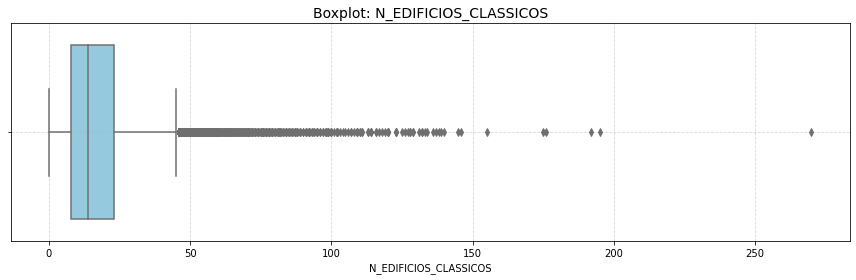

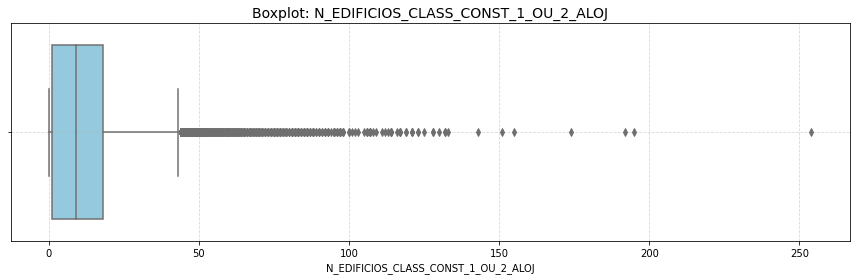

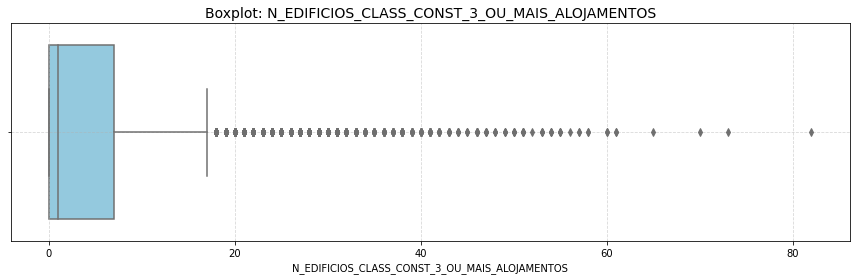

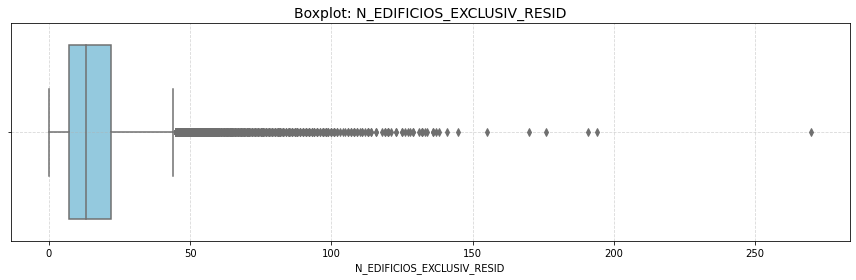

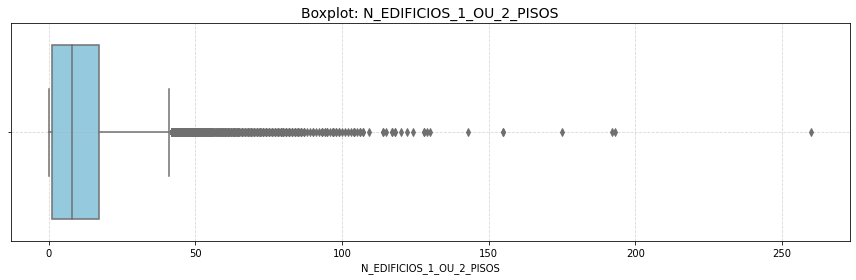

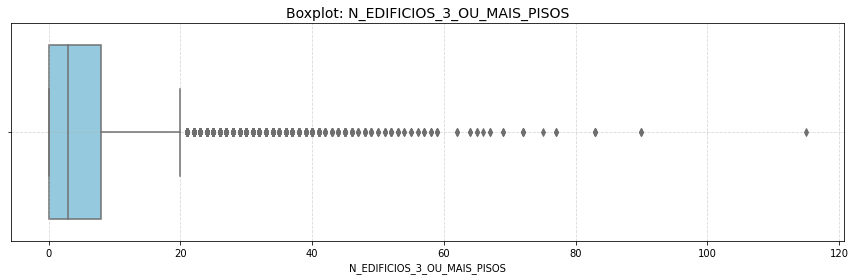

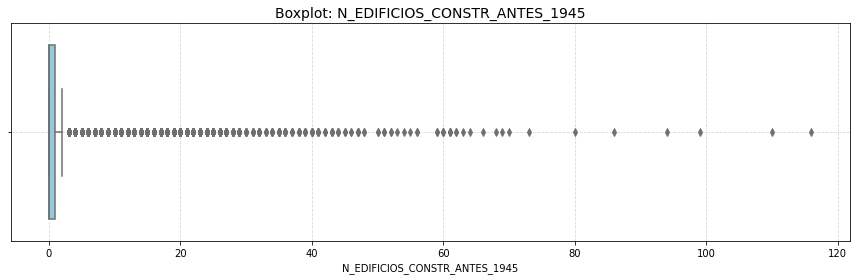

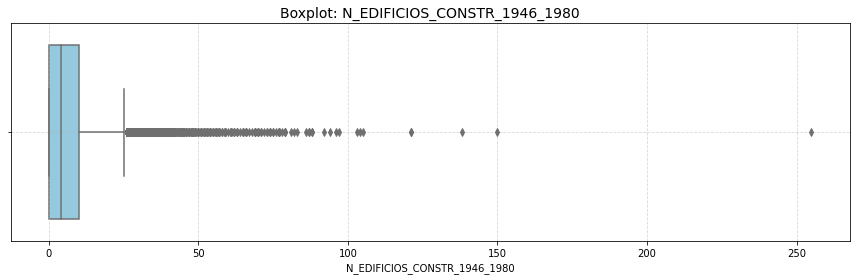

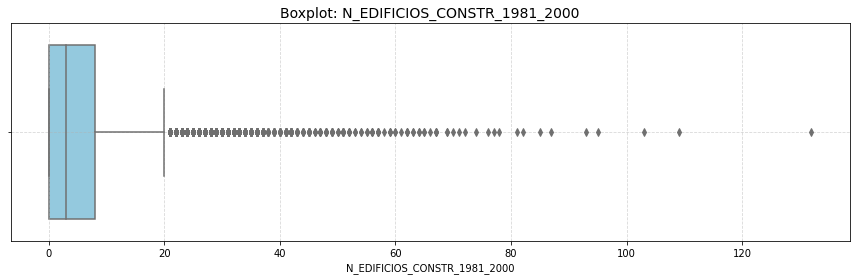

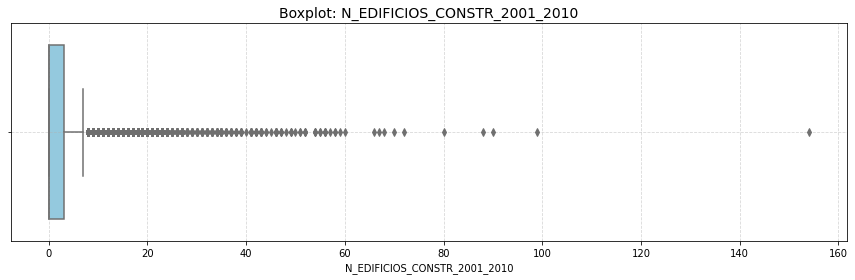

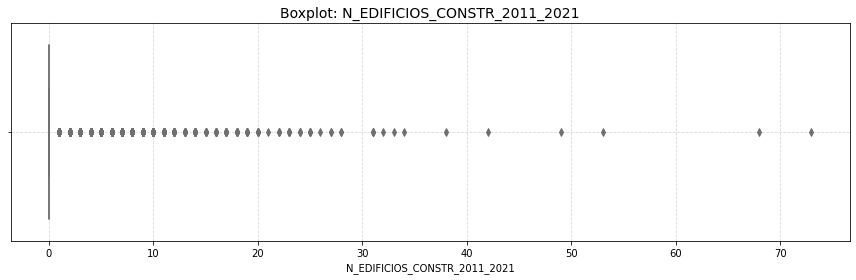

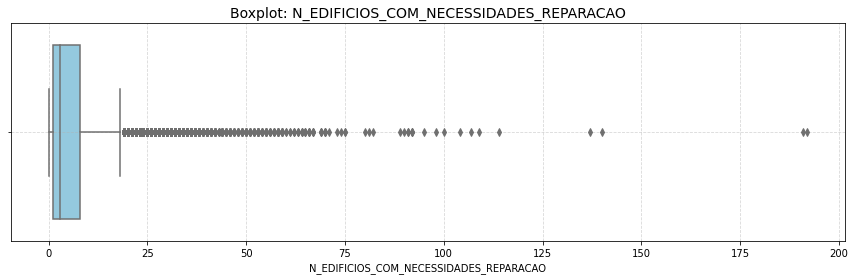

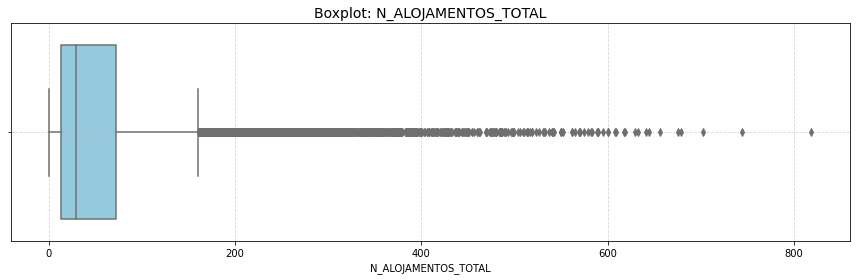

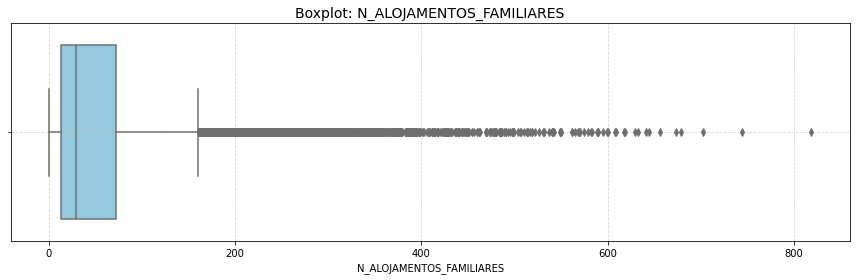

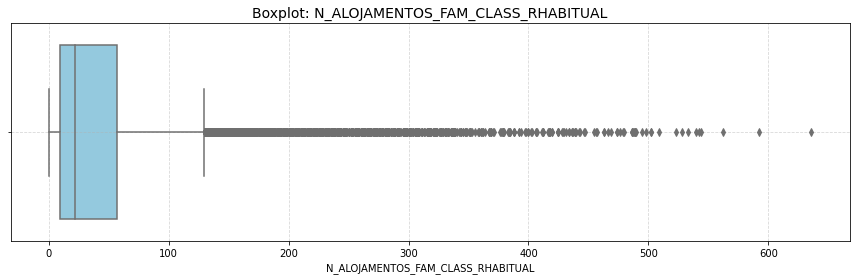

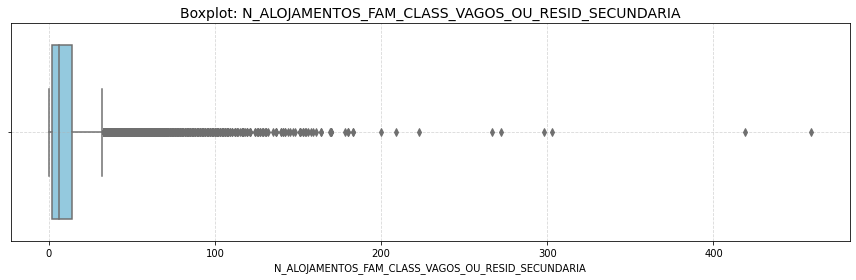

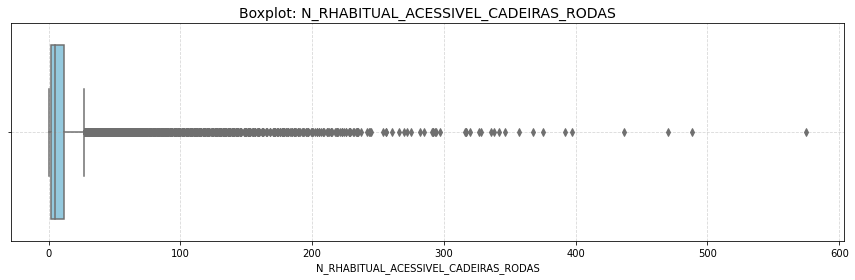

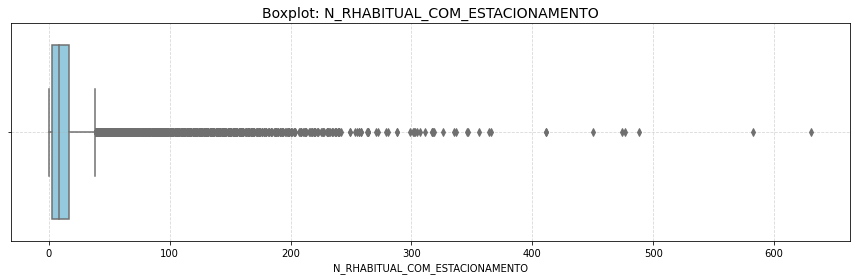

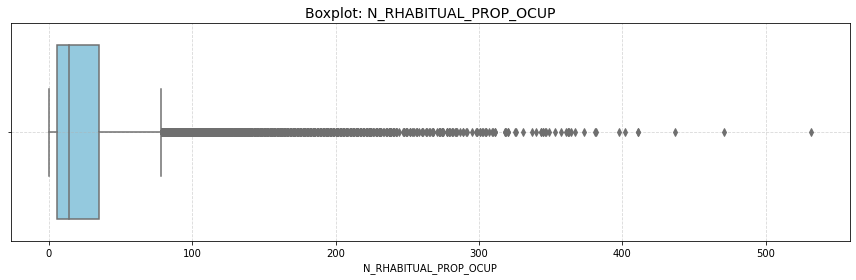

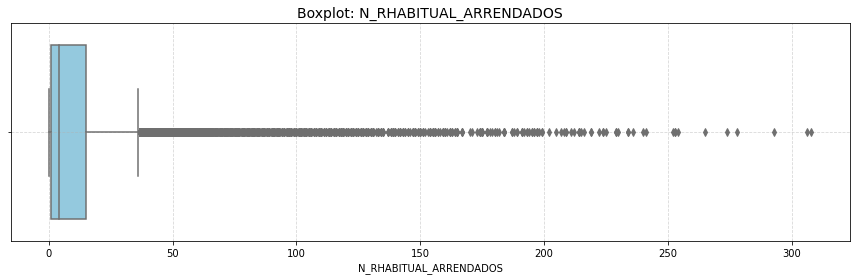

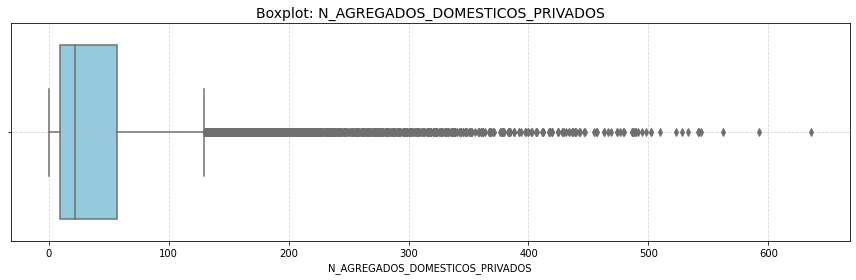

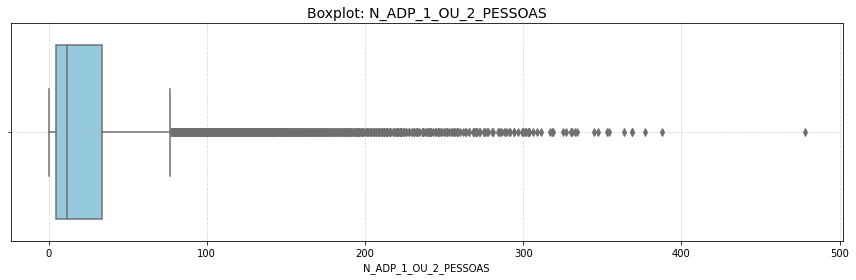

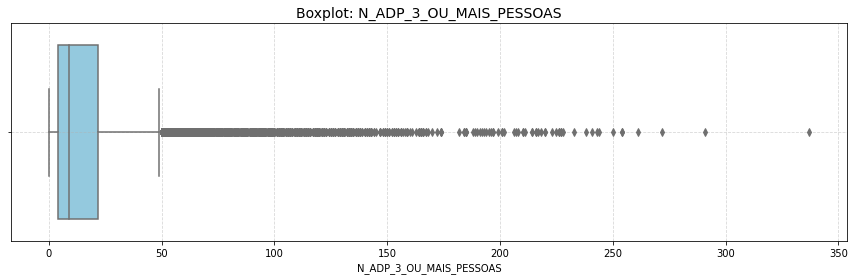

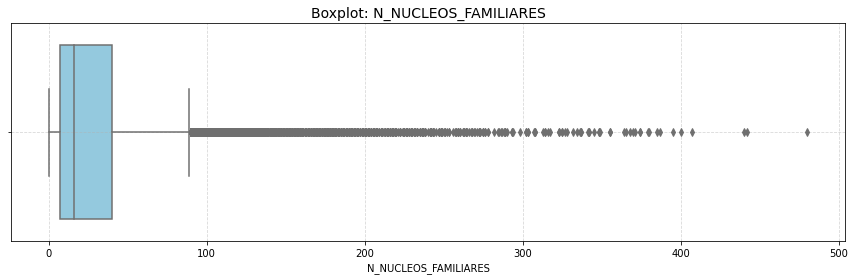

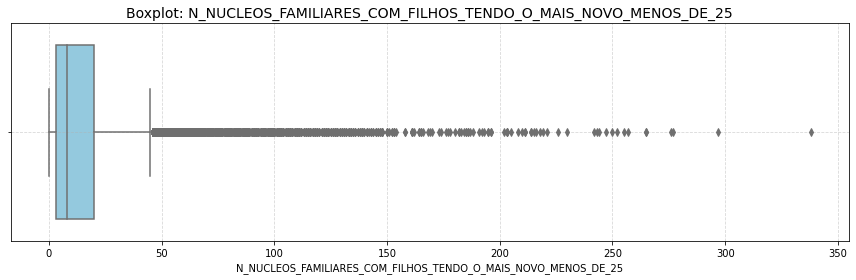

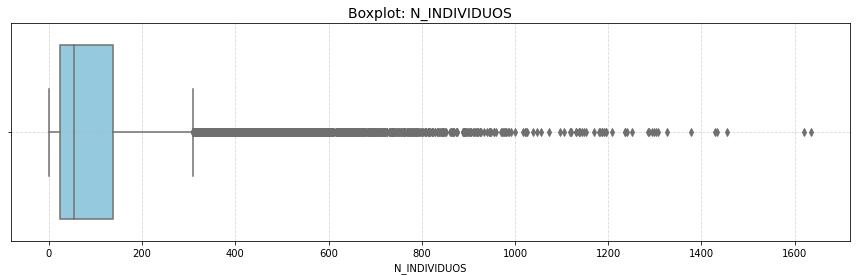

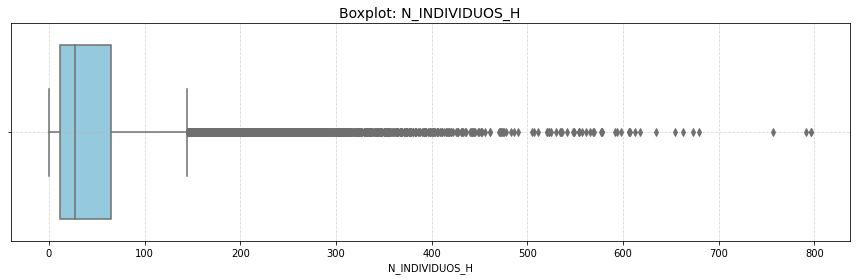

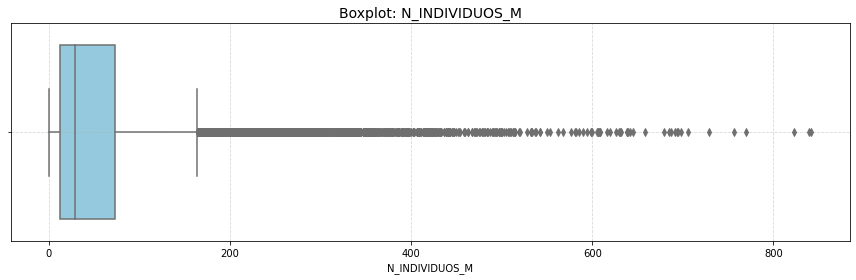

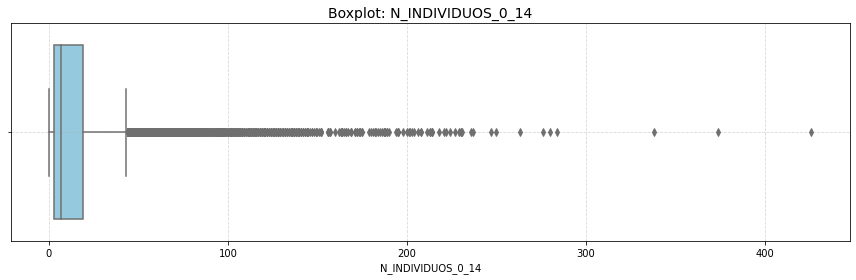

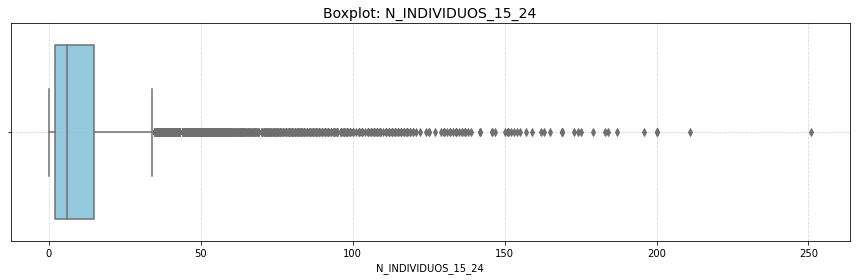

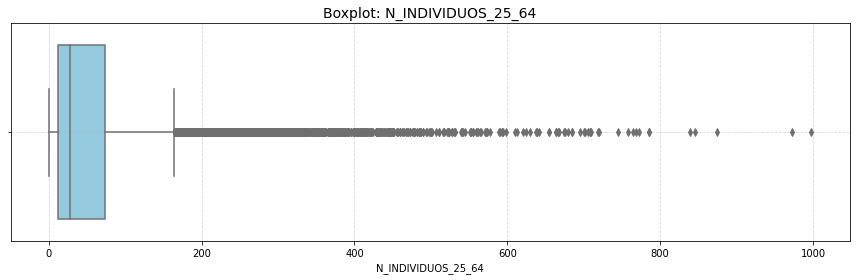

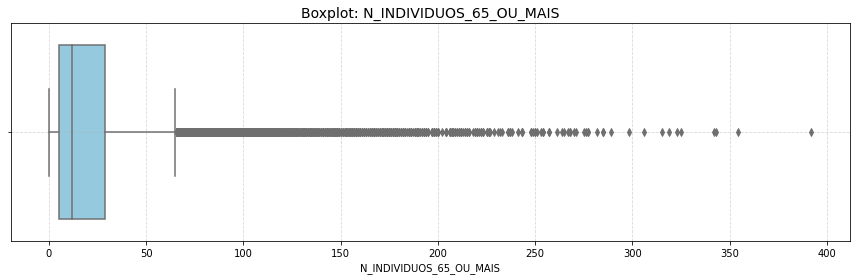

In [79]:
def plot_all_boxplots(df, figsize=(12, 4)):
    for col in df.columns:
        plt.figure(figsize=figsize)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(f'Boxplot: {col}', fontsize=14)
        plt.xlabel(col)
        plt.grid(linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

plot_all_boxplots(df_numeric)

## 4. Preprocessing

In this section, we apply a number of preprocessing steps. However, they are not chained in order to create a single, fully preprocessed version of the data. Rather, various datasets are created, with various levels and types of preprocessing, and they are later compared to find out which one performs the best with the SOM.

### 4.1. Scaling and Variance Thresholding

In [80]:
def scale_and_threshold(df, var_thresh=0.1):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    vt = VarianceThreshold(var_thresh)
    filtered = vt.fit_transform(scaled)
    cols = [c for i,c in enumerate(df.columns) if vt.variances_[i] > var_thresh]
    return pd.DataFrame(filtered, columns=cols, index=df.index)

orig_df = df_numeric.copy()
orig_scaled = scale_and_threshold(orig_df)

In [81]:
orig_scaled.head()

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ,N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_1_OU_2_PISOS,N_EDIFICIOS_3_OU_MAIS_PISOS,N_EDIFICIOS_CONSTR_ANTES_1945,N_EDIFICIOS_CONSTR_1946_1980,N_EDIFICIOS_CONSTR_1981_2000,N_EDIFICIOS_CONSTR_2001_2010,N_EDIFICIOS_CONSTR_2011_2021,N_EDIFICIOS_COM_NECESSIDADES_REPARACAO,N_ALOJAMENTOS_TOTAL,N_ALOJAMENTOS_FAMILIARES,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL,N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA,N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_COM_ESTACIONAMENTO,N_RHABITUAL_PROP_OCUP,N_RHABITUAL_ARRENDADOS,N_AGREGADOS_DOMESTICOS_PRIVADOS,N_ADP_1_OU_2_PESSOAS,N_ADP_3_OU_MAIS_PESSOAS,N_NUCLEOS_FAMILIARES,N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25,N_INDIVIDUOS,N_INDIVIDUOS_H,N_INDIVIDUOS_M,N_INDIVIDUOS_0_14,N_INDIVIDUOS_15_24,N_INDIVIDUOS_25_64,N_INDIVIDUOS_65_OU_MAIS
0,-0.889802,-0.665281,-0.500812,-0.866775,-0.552185,-0.723569,-0.335452,-0.441562,-0.592549,-0.473884,-0.286911,-0.461782,-0.679131,-0.678601,-0.663375,-0.566926,-0.407527,-0.491643,-0.609812,-0.510538,-0.664040,-0.629550,-0.648781,-0.644264,-0.612965,-0.669939,-0.674599,-0.660248,-0.670538,-0.517104,-0.655959,-0.606050
1,-0.559367,-0.530213,-0.078755,-0.533483,-0.337899,-0.471169,-0.335452,-0.034701,-0.457674,-0.473884,-0.286911,0.238942,-0.318493,-0.317869,-0.339556,-0.161567,-0.445380,-0.560513,-0.368518,-0.181908,-0.340390,-0.203275,-0.526583,-0.456234,-0.570596,-0.450634,-0.484408,-0.417341,-0.543765,-0.574659,-0.408212,-0.302241
2,-0.295019,0.010056,-0.641498,-0.333508,-0.052184,-0.471169,-0.335452,0.270445,-0.592549,-0.089866,-0.286911,-0.111420,-0.532204,-0.531636,-0.501465,-0.509018,-0.331822,-0.457208,-0.585682,-0.305144,-0.502215,-0.479100,-0.485850,-0.503242,-0.528227,-0.526020,-0.528298,-0.519618,-0.501507,-0.459548,-0.556860,-0.363003
3,-0.228932,0.010056,-0.500812,-0.200191,0.090673,-0.597369,0.444805,-0.238131,-0.187924,-0.281875,-0.286911,0.355729,-0.532204,-0.531636,-0.517656,-0.451109,-0.256117,-0.457208,-0.585682,-0.222987,-0.518397,-0.454025,-0.567316,-0.526745,-0.570596,-0.546580,-0.542928,-0.545187,-0.501507,-0.632214,-0.544473,-0.393384
4,0.167590,-0.597747,1.609474,0.199759,-0.552185,1.295629,-0.335452,-0.339846,1.025949,0.102143,-0.286911,0.589303,1.003845,1.004817,1.150011,0.243792,-0.142559,1.367844,1.055118,0.845059,1.148397,0.849875,1.510047,1.400563,2.056276,1.324361,1.285823,1.346931,1.695904,2.130433,1.412722,0.062330


### 4.2. Removing highly correlated variables

In [82]:
def pairwise_spearman(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute Spearman ρ for each unique pair of columns in df.
    Returns a DataFrame with columns ['Var1','Var2','SpearmanRho'] 
    sorted by |SpearmanRho| descending.
    """
    # 1. full Spearman correlation matrix
    corr = df.corr(method='spearman')
    
    # 2. mask out the lower triangle & diagonal
    mask = np.triu(np.ones(corr.shape, dtype=bool), k=1)
    
    # 3. keep only upper‐triangle entries, then stack into long form
    pairs = (
        corr
        .where(mask)    # keep only entries where mask==True
        .stack()        # drop NaNs and reshape
        .reset_index()  # turn index into columns
    )
    pairs.columns = ['Var1', 'Var2', 'SpearmanRho']
    
    # 4. sort by absolute correlation
    pairs['AbsRho'] = pairs['SpearmanRho'].abs()
    pairs = pairs.sort_values('AbsRho', ascending=False).drop(columns='AbsRho')
    
    return pairs


In [83]:
df_pairs = pairwise_spearman(orig_scaled)


high_corr = df_pairs[df_pairs['SpearmanRho'].abs() > 0.8]
high_corr

,Var1,Var2,SpearmanRho
306,N_ALOJAMENTOS_TOTAL,N_ALOJAMENTOS_FAMILIARES,0.999935
348,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL,N_AGREGADOS_DOMESTICOS_PRIVADOS,0.999015
476,N_INDIVIDUOS,N_INDIVIDUOS_M,0.994986
475,N_INDIVIDUOS,N_INDIVIDUOS_H,0.994496
2,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_EXCLUSIV_RESID,0.992854
...,...,...,...
447,N_ADP_1_OU_2_PESSOAS,N_INDIVIDUOS_0_14,0.823358
72,N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL,0.819828
78,N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,N_AGREGADOS_DOMESTICOS_PRIVADOS,0.819266
417,N_RHABITUAL_PROP_OCUP,N_INDIVIDUOS_65_OU_MAIS,0.819172


In [84]:
variances = orig_df.var(ddof=0)

var_table = (
    variances
    .reset_index()
    .rename(columns={'index':'Variable', 0:'Variance'})
    .sort_values('Variance', ascending=False)
)
var_table

,Variable,Variance
25,N_INDIVIDUOS,21291.453198
30,N_INDIVIDUOS_25_64,6516.973774
27,N_INDIVIDUOS_M,6118.247756
12,N_ALOJAMENTOS_TOTAL,5605.128400
13,N_ALOJAMENTOS_FAMILIARES,5602.181402
26,N_INDIVIDUOS_H,4672.084084
20,N_AGREGADOS_DOMESTICOS_PRIVADOS,3818.653489
14,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL,3814.658252
23,N_NUCLEOS_FAMILIARES,1810.195640
18,N_RHABITUAL_PROP_OCUP,1717.538106


In [85]:
# 3) for each correlated pair, pick the var with the smaller raw variance
vars_to_drop = (
    high_corr
    .apply(
        lambda row: row['Var1']
                    if variances[row['Var1']] < variances[row['Var2']]
                    else row['Var2'],
        axis=1
    )
    .unique()
    .tolist()
)

vars_to_drop

['N_ALOJAMENTOS_FAMILIARES',
 'N_ALOJAMENTOS_FAM_CLASS_RHABITUAL',
 'N_INDIVIDUOS_M',
 'N_INDIVIDUOS_H',
 'N_EDIFICIOS_EXCLUSIV_RESID',
 'N_NUCLEOS_FAMILIARES',
 'N_INDIVIDUOS_25_64',
 'N_AGREGADOS_DOMESTICOS_PRIVADOS',
 'N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25',
 'N_ADP_3_OU_MAIS_PESSOAS',
 'N_ADP_1_OU_2_PESSOAS',
 'N_ALOJAMENTOS_TOTAL',
 'N_INDIVIDUOS_0_14',
 'N_EDIFICIOS_1_OU_2_PISOS',
 'N_INDIVIDUOS_15_24',
 'N_RHABITUAL_PROP_OCUP',
 'N_INDIVIDUOS_65_OU_MAIS',
 'N_RHABITUAL_ARRENDADOS',
 'N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS',
 'N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA']

In [86]:
reduced_df = orig_scaled.copy().drop(columns=vars_to_drop)

In [87]:
reduced_df.head()

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ,N_EDIFICIOS_3_OU_MAIS_PISOS,N_EDIFICIOS_CONSTR_ANTES_1945,N_EDIFICIOS_CONSTR_1946_1980,N_EDIFICIOS_CONSTR_1981_2000,N_EDIFICIOS_CONSTR_2001_2010,N_EDIFICIOS_CONSTR_2011_2021,N_EDIFICIOS_COM_NECESSIDADES_REPARACAO,N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_COM_ESTACIONAMENTO,N_INDIVIDUOS
0,-0.889802,-0.665281,-0.723569,-0.335452,-0.441562,-0.592549,-0.473884,-0.286911,-0.461782,-0.407527,-0.491643,-0.669939
1,-0.559367,-0.530213,-0.471169,-0.335452,-0.034701,-0.457674,-0.473884,-0.286911,0.238942,-0.445380,-0.560513,-0.450634
2,-0.295019,0.010056,-0.471169,-0.335452,0.270445,-0.592549,-0.089866,-0.286911,-0.111420,-0.331822,-0.457208,-0.526020
3,-0.228932,0.010056,-0.597369,0.444805,-0.238131,-0.187924,-0.281875,-0.286911,0.355729,-0.256117,-0.457208,-0.546580
4,0.167590,-0.597747,1.295629,-0.335452,-0.339846,1.025949,0.102143,-0.286911,0.589303,-0.142559,1.367844,1.324361


### 4.3. Dealing with compositional sets

In [88]:
def multiplicative_replacement(comp: np.ndarray, delta: float = 1e-3) -> np.ndarray:
    """
    Replace zeros in a compositional array by a small delta and rescale.
    
    Uses the standard multiplicative replacement formula:
    - Zero components are replaced by delta
    - Non-zero components are scaled by (1 - k*delta) / sum_original_nonzeros
    
    Parameters:
    -----------
    comp : np.ndarray
        Compositional data array of shape (n, D) where rows sum to 1
    delta : float, default=1e-3
        Small positive value to replace zeros
        
    Returns:
    --------
    np.ndarray
        Compositional array with zeros replaced, rows still sum to 1
    """
    comp = comp.copy()
    n, D = comp.shape
    
    for i in range(n):
        row = comp[i]
        zero_idx = row == 0
        k = zero_idx.sum()
        
        if k > 0:
            # Store original sum of non-zero components BEFORE modification
            original_nonzero_sum = row[~zero_idx].sum()
            
            # Replace zeros with delta
            row[zero_idx] = delta
            
            # Scale non-zero components using original sum
            nonzero_idx = ~zero_idx
            row[nonzero_idx] *= (1 - k * delta) / original_nonzero_sum
            
            comp[i] = row
    
    return comp

In [89]:
composition_groups = {
    "N_ALOJ": [
        "N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ",
        "N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS"
    ],
    "IS_RESIDENCIAL": [
        "N_EDIFICIOS_EXCLUSIV_RESID",
        "N_EDIFICIOS_NAO_EXCLUSIV_RESID"
    ],
    "PISOS": [
        "N_EDIFICIOS_1_OU_2_PISOS",
        "N_EDIFICIOS_3_OU_MAIS_PISOS"
    ],
    "CONSTR": [
        "N_EDIFICIOS_CONSTR_ANTES_1945",
        "N_EDIFICIOS_CONSTR_1946_1980",
        "N_EDIFICIOS_CONSTR_1981_2000",
        "N_EDIFICIOS_CONSTR_2001_2010",
        "N_EDIFICIOS_CONSTR_2011_2021"
    ],
    "NEC_REPAR": [
        "N_EDIFICIOS_COM_NECESSIDADES_REPARACAO",
        "N_EDIFICIOS_SEM_NECESSIDADES_REPARACAO"
    ],
    "ALOJ_FAM": [
        "N_ALOJAMENTOS_FAM_CLASS_RHABITUAL",
        "N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA"
    ],
    "CAD_RODAS": [
        "N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS",
        "N_RHABITUAL_NAO_ACESSIVEL_CADEIRAS_RODAS"
    ],
    "ESTACIONAMENTO": [
        "N_RHABITUAL_COM_ESTACIONAMENTO",
        "N_RHABITUAL_SEM_ESTACIONAMENTO"
    ],
    "OCUP": [
        "N_RHABITUAL_PROP_OCUP",
        "N_RHABITUAL_ARRENDADOS",
        "N_RHABITUAL_OCUPADOS_OUTR_SITUACAO"
    ],
    "ADP": [
        "N_ADP_1_OU_2_PESSOAS",
        "N_ADP_3_OU_MAIS_PESSOAS"
    ],
    "GENDER": [
        "N_INDIVIDUOS_H",
        "N_INDIVIDUOS_M"
    ],
    "AGE": [
        "N_INDIVIDUOS_0_14",
        "N_INDIVIDUOS_15_24",
        "N_INDIVIDUOS_25_64",
        "N_INDIVIDUOS_65_OU_MAIS"
    ]
}


In [90]:
# create derived features only for ratios & ILR
base_for_comp = df_numeric.copy()
# add the five extra columns
base_for_comp["N_EDIFICIOS_NAO_EXCLUSIV_RESID"] = base_for_comp["N_EDIFICIOS_CLASSICOS"] - base_for_comp["N_EDIFICIOS_EXCLUSIV_RESID"]
base_for_comp["N_EDIFICIOS_SEM_NECESSIDADES_REPARACAO"] = base_for_comp["N_EDIFICIOS_CLASSICOS"] - base_for_comp["N_EDIFICIOS_COM_NECESSIDADES_REPARACAO"]
base_for_comp["N_RHABITUAL_NAO_ACESSIVEL_CADEIRAS_RODAS"] = base_for_comp["N_ALOJAMENTOS_FAM_CLASS_RHABITUAL"] - base_for_comp["N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS"]
base_for_comp["N_RHABITUAL_SEM_ESTACIONAMENTO"] = base_for_comp["N_ALOJAMENTOS_FAM_CLASS_RHABITUAL"] - base_for_comp["N_RHABITUAL_COM_ESTACIONAMENTO"]
base_for_comp["N_RHABITUAL_OCUPADOS_OUTR_SITUACAO"] = base_for_comp["N_ALOJAMENTOS_FAM_CLASS_RHABITUAL"] - base_for_comp["N_RHABITUAL_PROP_OCUP"] - base_for_comp["N_RHABITUAL_ARRENDADOS"]

In [91]:
ratios = base_for_comp.copy()
for parts in composition_groups.values():
    comp = ratios[parts].values
    comp = multiplicative_replacement(comp, delta=1e-3)
    comp = comp / comp.sum(axis=1, keepdims=True)
    ratios[parts] = comp
ratios_scaled = scale_and_threshold(ratios)

In [92]:
ratios_scaled.head()

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ,N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_1_OU_2_PISOS,N_EDIFICIOS_3_OU_MAIS_PISOS,N_EDIFICIOS_CONSTR_ANTES_1945,N_EDIFICIOS_CONSTR_1946_1980,N_EDIFICIOS_CONSTR_1981_2000,N_EDIFICIOS_CONSTR_2001_2010,N_EDIFICIOS_CONSTR_2011_2021,N_EDIFICIOS_COM_NECESSIDADES_REPARACAO,N_ALOJAMENTOS_TOTAL,N_ALOJAMENTOS_FAMILIARES,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL,N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA,N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_COM_ESTACIONAMENTO,N_RHABITUAL_PROP_OCUP,N_RHABITUAL_ARRENDADOS,N_AGREGADOS_DOMESTICOS_PRIVADOS,N_ADP_1_OU_2_PESSOAS,N_ADP_3_OU_MAIS_PESSOAS,N_NUCLEOS_FAMILIARES,N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25,N_INDIVIDUOS,N_INDIVIDUOS_H,N_INDIVIDUOS_M,N_INDIVIDUOS_0_14,N_INDIVIDUOS_15_24,N_INDIVIDUOS_25_64,N_INDIVIDUOS_65_OU_MAIS,N_EDIFICIOS_NAO_EXCLUSIV_RESID,N_EDIFICIOS_SEM_NECESSIDADES_REPARACAO,N_RHABITUAL_NAO_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_SEM_ESTACIONAMENTO,N_RHABITUAL_OCUPADOS_OUTR_SITUACAO
0,-0.889802,0.212798,-0.212798,0.386011,0.985937,-0.985937,-0.451967,1.026894,-0.231814,-0.612243,-0.371267,0.483531,-0.679131,-0.678601,-0.220110,0.220110,0.253984,-0.329642,0.570429,-0.195779,-0.664040,0.093519,-0.093519,-0.644264,-0.612965,-0.669939,-0.233022,0.233022,-1.761419,1.800563,-0.377604,0.404559,-0.386011,-0.483531,-0.253984,0.329642,-0.793552
1,-0.559367,-0.269391,0.269391,0.386011,0.429902,-0.429902,-0.451967,1.107508,-0.318773,-0.612243,-0.371267,1.715955,-0.318493,-0.317869,-0.106315,0.106315,-1.179425,-1.443398,-0.380946,0.500131,-0.340390,1.186553,-1.186553,-0.456234,-0.570596,-0.450634,-0.728021,0.728021,-0.905944,-0.956523,0.567941,0.429569,-0.386011,-1.715955,1.179425,1.443398,-0.156140
2,-0.295019,0.830275,-0.830275,-0.232265,0.601763,-0.601763,-0.451967,1.084943,-0.773395,0.025484,-0.371267,0.117867,-0.532204,-0.531636,0.424728,-0.424728,-0.276908,-0.887915,-1.282471,0.673891,-0.502215,0.093519,-0.093519,-0.503242,-0.528227,-0.526020,-0.119084,0.119084,-0.241796,0.128014,-0.777147,0.710305,0.232265,-0.117867,0.276908,0.887915,1.349983
3,-0.228932,0.655625,-0.655625,0.386011,0.808917,-0.808917,0.858273,-0.111138,-0.118215,-0.318096,-0.371267,0.936259,-0.532204,-0.531636,0.123804,-0.123804,0.367746,-0.848039,-1.187773,1.418578,-0.518397,0.718110,-0.718110,-0.526745,-0.570596,-0.546580,0.048149,-0.048149,-0.093475,-1.137071,-0.192920,0.723040,-0.386011,-0.936259,-0.367746,0.848039,-0.225298
4,0.167590,-1.151107,1.151107,0.386011,-1.022325,1.022325,-0.451967,-0.568680,1.022441,0.009437,-0.371267,0.641986,1.003845,1.004817,0.675876,-0.675876,-1.032409,-0.110150,-0.126670,0.198650,1.148397,-0.289510,0.289510,1.400563,2.056276,1.324361,-0.245765,0.245765,0.625362,0.773041,0.497461,-1.084406,-0.386011,-0.641986,1.032409,0.110150,-0.112004


In [93]:
ratios.head()

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ,N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_1_OU_2_PISOS,N_EDIFICIOS_3_OU_MAIS_PISOS,N_EDIFICIOS_CONSTR_ANTES_1945,N_EDIFICIOS_CONSTR_1946_1980,N_EDIFICIOS_CONSTR_1981_2000,N_EDIFICIOS_CONSTR_2001_2010,N_EDIFICIOS_CONSTR_2011_2021,N_EDIFICIOS_COM_NECESSIDADES_REPARACAO,N_ALOJAMENTOS_TOTAL,N_ALOJAMENTOS_FAMILIARES,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL,N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA,N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_COM_ESTACIONAMENTO,N_RHABITUAL_PROP_OCUP,N_RHABITUAL_ARRENDADOS,N_AGREGADOS_DOMESTICOS_PRIVADOS,N_ADP_1_OU_2_PESSOAS,N_ADP_3_OU_MAIS_PESSOAS,N_NUCLEOS_FAMILIARES,N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25,N_INDIVIDUOS,N_INDIVIDUOS_H,N_INDIVIDUOS_M,N_INDIVIDUOS_0_14,N_INDIVIDUOS_15_24,N_INDIVIDUOS_25_64,N_INDIVIDUOS_65_OU_MAIS,N_EDIFICIOS_NAO_EXCLUSIV_RESID,N_EDIFICIOS_SEM_NECESSIDADES_REPARACAO,N_RHABITUAL_NAO_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_SEM_ESTACIONAMENTO,N_RHABITUAL_OCUPADOS_OUTR_SITUACAO
0,4.0,0.750000,0.250000,0.999000,0.999000,0.001000,0.001000,0.747750,0.249250,0.001000,0.001,0.500000,7.0,7.0,0.714286,0.285714,0.400000,0.400000,0.799200,0.199800,5.0,0.600000,0.400000,5.0,2.0,13.0,0.461538,0.538462,0.001000,0.230538,0.461077,0.307385,0.001000,0.500000,0.600000,0.600000,0.001000
1,9.0,0.555556,0.444444,0.999000,0.777778,0.222222,0.001000,0.775444,0.221556,0.001000,0.001,0.888889,34.0,34.0,0.735294,0.264706,0.040000,0.001000,0.560000,0.360000,25.0,0.800000,0.200000,13.0,3.0,45.0,0.422222,0.577778,0.066667,0.044444,0.577778,0.311111,0.001000,0.111111,0.960000,0.999000,0.080000
2,13.0,0.999000,0.001000,0.923077,0.846154,0.153846,0.001000,0.767692,0.076769,0.153538,0.001,0.384615,18.0,18.0,0.833333,0.166667,0.266667,0.200000,0.333333,0.400000,15.0,0.600000,0.400000,11.0,4.0,34.0,0.470588,0.529412,0.117647,0.117647,0.411765,0.352941,0.076923,0.615385,0.733333,0.800000,0.266667
3,14.0,0.928571,0.071429,0.999000,0.928571,0.071429,0.285429,0.356786,0.285429,0.071357,0.001,0.642857,18.0,18.0,0.777778,0.222222,0.428571,0.214286,0.357143,0.571429,14.0,0.714286,0.285714,10.0,3.0,31.0,0.483871,0.516129,0.129032,0.032258,0.483871,0.354839,0.001000,0.357143,0.571429,0.785714,0.071429
4,20.0,0.200000,0.800000,0.999000,0.200000,0.800000,0.001000,0.199600,0.648700,0.149700,0.001,0.550000,133.0,133.0,0.879699,0.120301,0.076923,0.478632,0.623932,0.290598,117.0,0.529915,0.470085,92.0,65.0,304.0,0.460526,0.539474,0.184211,0.161184,0.569079,0.085526,0.001000,0.450000,0.923077,0.521368,0.085470


### 4.4. Isometric Log-Ratio Transformation

In [94]:
def ilr_transform_block(df, parts):
    
    comp = df[parts].values
    
    # Handle zeros with multiplicative replacement
    comp = multiplicative_replacement(comp, delta=1e-3)
    
    comp = comp / comp.sum(axis=1, keepdims=True)
    
    n, d = comp.shape
    
    ilr = np.zeros((n, d-1))
    
    for k in range(1, d):
        coeff = np.sqrt(k / (k + 1))
        
        log_geom_mean_first_k = np.mean(np.log(comp[:, :k]), axis=1)
        
        log_kplus1_component = np.log(comp[:, k])
        
        ilr[:, k-1] = coeff * (log_geom_mean_first_k - log_kplus1_component)
    
    cols = [f"{parts[0]}_ilr{k}" for k in range(1, d)]
    
    return pd.DataFrame(ilr, columns=cols, index=df.index)

# build ilr-only DataFrame
ilr_blocks = [ilr_transform_block(base_for_comp, parts) for parts in composition_groups.values()]
ilr_only = pd.concat(ilr_blocks, axis=1)

# keep non-compositional vars with log transform
all_comp_cols = [c for parts in composition_groups.values() for c in parts]
other_cols = [c for c in base_for_comp.columns if c not in all_comp_cols]
log_other = np.log1p(base_for_comp[other_cols])

# combine log-transformed others + ilr coords
ilr_full = pd.concat([log_other, ilr_only], axis=1)

ilr_scaled = scale_and_threshold(ilr_full)

In [95]:
ilr_scaled.head()

,N_EDIFICIOS_CLASSICOS,N_ALOJAMENTOS_TOTAL,N_ALOJAMENTOS_FAMILIARES,N_AGREGADOS_DOMESTICOS_PRIVADOS,N_NUCLEOS_FAMILIARES,N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25,N_INDIVIDUOS,N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ_ilr1,N_EDIFICIOS_EXCLUSIV_RESID_ilr1,N_EDIFICIOS_1_OU_2_PISOS_ilr1,N_EDIFICIOS_CONSTR_ANTES_1945_ilr1,N_EDIFICIOS_CONSTR_ANTES_1945_ilr2,N_EDIFICIOS_CONSTR_ANTES_1945_ilr3,N_EDIFICIOS_CONSTR_ANTES_1945_ilr4,N_EDIFICIOS_COM_NECESSIDADES_REPARACAO_ilr1,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL_ilr1,N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS_ilr1,N_RHABITUAL_COM_ESTACIONAMENTO_ilr1,N_RHABITUAL_PROP_OCUP_ilr1,N_RHABITUAL_PROP_OCUP_ilr2,N_ADP_1_OU_2_PESSOAS_ilr1,N_INDIVIDUOS_H_ilr1,N_INDIVIDUOS_0_14_ilr1,N_INDIVIDUOS_0_14_ilr2,N_INDIVIDUOS_0_14_ilr3
0,-1.170655,-1.080151,-1.074230,-1.051734,-0.865130,-0.927792,-0.956974,-0.139807,0.538605,1.198793,-1.066565,-0.285379,1.042567,0.411953,0.409970,-0.342255,0.305656,-0.180587,-0.201593,1.952069,-0.026955,-0.121450,-3.487077,-1.390125,-1.073320
1,-0.356418,0.116042,0.118165,0.095383,-0.171686,-0.684447,-0.098874,-0.309058,0.538605,0.053316,-1.077150,-0.247856,1.033866,0.402246,0.992800,-0.282990,-0.915416,-1.970376,-0.537712,-0.031532,0.571047,-0.365379,0.104961,-0.487915,-0.466761
2,0.038834,-0.379088,-0.375393,-0.284430,-0.297845,-0.495694,-0.296013,0.983062,-1.384498,0.144886,-1.074225,0.043250,-0.694410,0.874896,0.278236,0.047639,0.038709,-0.450607,-0.759838,-0.687555,-0.026955,-0.065834,-0.144179,0.464347,-0.284497
3,0.119880,-0.379088,-0.375393,-0.334919,-0.369057,-0.684447,-0.360654,0.143676,0.538605,0.319160,0.794412,0.355284,0.213951,1.522898,0.574716,-0.152990,0.357529,-0.426653,-0.862220,0.024014,0.284490,0.015591,0.707638,-0.189810,-0.518069
4,0.515132,1.204105,1.202773,1.278683,1.378025,1.686865,1.265673,-0.620205,0.538605,-0.481347,-0.682154,-0.731592,-0.602177,0.965727,0.466214,0.261470,-0.610148,-0.092507,-0.423022,-0.086950,-0.201122,-0.127679,-0.062130,0.514179,0.896168


### 4.5. PCA

In [96]:
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(orig_scaled)

n_pc = pca.n_components_

orig_pca = pd.DataFrame(
    X_pca,
    index=orig_scaled.index,
    columns=[f"PC_{i+1}" for i in range(n_pc)]
)

In [97]:
orig_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-3.104374,-1.448024,-0.137806,-0.223910,-0.072924,0.159643,0.054058
1,-1.905227,-0.814721,-0.768046,-0.356932,0.081535,0.195178,0.110919
2,-2.353719,-0.190254,-0.228562,-0.404076,-0.056937,0.305781,0.538470
3,-2.357264,0.097423,-0.477658,-0.034262,-0.618821,-0.033252,-0.195389
4,5.545181,-0.833039,0.906735,-0.136630,0.243702,-1.531637,-0.166952


### 4.6. ILR + PCA

In [98]:
pca_2 = PCA(n_components=0.90)
pca_ilr = pca_2.fit_transform(ilr_scaled)

n_pc_ilr = pca_2.n_components_

ilr_pca = pd.DataFrame(
    pca_ilr,
    index=ilr_scaled.index,
    columns=[f"PC_{i+1}" for i in range(n_pc_ilr)]
)

In [99]:
ilr_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14
0,2.747166,1.481340,-1.045730,0.615965,-1.737247,0.511352,-0.008106,-2.961657,1.684011,-0.263722,-1.375415,-0.128110,0.338794,0.961845
1,-0.175462,2.190812,-1.033574,-0.265613,-0.865189,0.857928,-0.143920,0.477628,-0.004649,0.082875,-0.437408,-0.972363,-0.345378,-0.167379
2,0.688644,0.578273,-0.030888,-0.785166,0.187175,0.843445,-0.227227,-0.066391,-0.218449,-0.822305,-0.190335,0.971771,-0.083957,-0.683644
3,0.897821,1.081619,-0.729260,-0.632735,-0.169461,-0.743503,0.527483,0.223262,-1.311776,-0.565358,-0.186388,0.288412,0.298140,-0.422734
4,-3.463654,-1.044029,-0.292752,-0.427756,-0.613453,0.510268,0.385176,-0.168487,-0.600395,-0.323731,-0.438946,-0.210672,-0.828599,-0.431321


## 5. Data version comparison

Here, we compare the different versions of the data, with different preprocessing steps applied to them. We base the comparisons on Quantization Error (QE), Topographic Error (QE), and a composite index created from the two.

In [100]:
def evaluate_som(data):
    som = MiniSom(10,10,data.shape[1],sigma=1.0,learning_rate=0.5,random_seed=0)
    som.train(data.values,100000)
    qe = som.quantization_error(data.values)
    te = som.topographic_error(data.values)
    return qe, te

In [101]:
results = []
for name, df in [
    ("Original", orig_scaled),
    ("Ratios", ratios_scaled),
    ("ILR", ilr_scaled),
    ("PCA", orig_pca),
    ("ILR+PCA", ilr_pca),
    ("Reduced", reduced_df)
]:
    qe, te = evaluate_som(df)
    results.append({
        "Dataset": name,
        "Features": df.shape[1],
        "QE": qe,
        "TE": te
    })
data_results_df = pd.DataFrame(results)

In [102]:
data_results_df

,Dataset,Features,QE,TE
0,Original,32,1.737070,0.314644
1,Ratios,37,3.384265,0.578275
2,ILR,25,2.627473,0.584411
3,PCA,7,1.257363,0.452325
4,ILR+PCA,14,2.331579,0.555971
5,Reduced,12,1.144631,0.442910


In [103]:
# Weights for QE vs TE
w_Q, w_T = 0.5, 0.5

# Normalize errors to [0,1]
data_results_df['norm_QE'] = (data_results_df['QE'] - data_results_df['QE'].min()) / (data_results_df['QE'].max() - data_results_df['QE'].min())
data_results_df['norm_TE'] = (data_results_df['TE'] - data_results_df['TE'].min()) / (data_results_df['TE'].max() - data_results_df['TE'].min())

data_results_df['composite_score'] = w_Q * data_results_df['norm_QE'] + w_T * data_results_df['norm_TE']

data_results_sorted = data_results_df.sort_values(by='composite_score')

In [104]:
data_results_sorted

,Dataset,Features,QE,TE,norm_QE,norm_TE,composite_score
0,Original,32,1.737070,0.314644,0.264525,0.000000,0.132262
5,Reduced,12,1.144631,0.442910,0.000000,0.475468,0.237734
3,PCA,7,1.257363,0.452325,0.050335,0.510370,0.280353
4,ILR+PCA,14,2.331579,0.555971,0.529974,0.894579,0.712276
2,ILR,25,2.627473,0.584411,0.662091,1.000000,0.831045
1,Ratios,37,3.384265,0.578275,1.000000,0.977256,0.988628


In [138]:
data_results_sorted.to_clipboard()

## 6. SOM Hyperparameter Tuning

In this section, we test different hyperparameter combinations for the SOM, and compare them based on the same Quantization Error (QE), Topographic Error (QE), and a composite index created from the two. We also plot the Pareto frontier to visually compare the options. Only the previously selected dataset is utilized.

In [106]:
param_grid = {
    'x_dim': [25,35,45],
    'y_dim': [25,35,45],
    'sigma': [1,5,10],
    'learning_rate': [0.3,0.5,0.7],
    'num_iterations': [50000,100000,150000]
}

In [107]:
tune_results = []
for xd in param_grid['x_dim']:
    for yd in param_grid['y_dim']:
        for sig in param_grid['sigma']:
            for lr in param_grid['learning_rate']:
                for iters in param_grid['num_iterations']:
                    som = MiniSom(xd, yd, orig_scaled.shape[1], sigma=sig,
                                  learning_rate=lr, random_seed=0)
                    som.train(orig_scaled.values, iters)
                    qe = som.quantization_error(orig_scaled.values)
                    te = som.topographic_error(orig_scaled.values)
                    tune_results.append({
                        'x_dim': xd,
                        'y_dim': yd,
                        'sigma': sig,
                        'learning_rate': lr,
                        'num_iterations': iters,
                        'QE': qe,
                        'TE': te
                    })

tune_df = pd.DataFrame(tune_results)

In [108]:
tune_df.sort_values(by='QE', ascending=True, inplace=True)
tune_df

,x_dim,y_dim,sigma,learning_rate,num_iterations,QE,TE
224,45,45,1,0.7,150000,0.992830,0.555701
221,45,45,1,0.5,150000,1.007375,0.474937
223,45,45,1,0.7,100000,1.017396,0.549759
197,45,35,1,0.7,150000,1.039421,0.578005
143,35,45,1,0.7,150000,1.040693,0.563843
...,...,...,...,...,...,...,...
107,35,25,10,0.7,150000,2.132989,0.013699
25,25,25,10,0.7,100000,2.147684,0.025738
20,25,25,10,0.3,150000,2.157101,0.009801
23,25,25,10,0.5,150000,2.219771,0.017287


### 6.1. Final Hyperparameter Set Selection

In [ ]:
output_notebook()
#output_file("pareto.html")

points = tune_df[['QE', 'TE']].values
pareto_mask = np.ones(points.shape[0], dtype=bool)
for i, (qe_i, te_i) in enumerate(points):
    for j, (qe_j, te_j) in enumerate(points):
        if (qe_j <= qe_i and te_j <= te_i) and ((qe_j < qe_i) or (te_j < te_i)):
            pareto_mask[i] = False
            break

tune_df['is_pareto'] = np.where(pareto_mask, 'Pareto', 'Non-Pareto')
source = ColumnDataSource(tune_df)

color_mapper = CategoricalColorMapper(factors=['Pareto', 'Non-Pareto'], palette=['red', 'gray'])

p = figure(title="QE vs TE with Pareto Frontier",
           x_axis_label='Quantization Error (QE)',
           y_axis_label='Topographic Error (TE)',
           tools="pan,wheel_zoom,box_zoom,reset,save")

p.circle('QE', 'TE',
         source=source,
         size=8,
         color={'field': 'is_pareto', 'transform': color_mapper},
         alpha=0.6,
         legend_field='is_pareto')

hover = HoverTool(tooltips=[
    ("Type", "@is_pareto"),
    ("QE", "@QE{0.000}"),
    ("TE", "@TE{0.000}"),
    ("Grid", "@x_dim × @y_dim"),
    ("σ", "@sigma"),
    ("lr", "@learning_rate"),
    ("iters", "@num_iterations")
])
p.add_tools(hover)

p.legend.location = "top_right"
p.legend.click_policy = "hide"

show(p)

Loading BokehJS ...

In [110]:
# Weights for QE vs TE
w_Q, w_T = 0.5, 0.5

# Normalize errors to [0,1]
tune_df['norm_QE'] = (tune_df['QE'] - tune_df['QE'].min()) / (tune_df['QE'].max() - tune_df['QE'].min())
tune_df['norm_TE'] = (tune_df['TE'] - tune_df['TE'].min()) / (tune_df['TE'].max() - tune_df['TE'].min())

tune_df['composite_score'] = w_Q * tune_df['norm_QE'] + w_T * tune_df['norm_TE']

df_sorted = tune_df.sort_values(by='composite_score')

In [111]:
cs_comparison = df_sorted[['x_dim','y_dim','sigma','learning_rate','num_iterations','QE','TE','composite_score']].head()
cs_comparison

,x_dim,y_dim,sigma,learning_rate,num_iterations,QE,TE,composite_score
227,45,45,5,0.3,150000,1.474490,0.033726,0.204953
225,45,45,5,0.3,50000,1.495145,0.028555,0.208650
226,45,45,5,0.3,100000,1.489894,0.034382,0.211366
228,45,45,5,0.5,50000,1.498027,0.040363,0.219318
229,45,45,5,0.5,100000,1.502790,0.039630,0.220542


In [140]:
cs_comparison.to_clipboard()

In [113]:
tuned = {'x':45,'y':45,'sigma':5,'learning_rate':0.3,'num_iterations':150000}

## 7. Clustering Method Evaluation

Now, we use the selected hyperparameter set to compare the performance of 4 clustering options: K-Means Clustering, Hierarchical Clustering, and the same two models but trained on SOM weights instead of input data. The goal is to both select a final clustering setup and assess the impact of the SOM on performance.

### 7.1. K-Fold Cross-Validation

In [114]:
def evaluate_with_cv(data, som_params, n_clusters=4, n_splits=5):

    def eval_metrics(X, labels):
        return (
            silhouette_score(X, labels),
            davies_bouldin_score(X, labels),
            calinski_harabasz_score(X, labels)
        )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    recs = []
    for fold, (train_idx, _) in enumerate(kf.split(data), start=1):
        X_train = data.iloc[train_idx]
        # Train SOM
        som = MiniSom(som_params['x'], som_params['y'], X_train.shape[1],
                      sigma=som_params['sigma'],
                      learning_rate=som_params['learning_rate'],
                      random_seed=0)
        som.train(X_train.values, som_params['num_iterations'])
        weights = som.get_weights().reshape(-1, X_train.shape[1])
        bmus = np.array([som.winner(x) for x in X_train.values])
        flat = bmus[:,0]*som_params['y'] + bmus[:,1]
        # SOM+HC
        hc = AgglomerativeClustering(n_clusters=n_clusters).fit(weights)
        sil, db, ch = eval_metrics(X_train, hc.labels_[flat])
        recs.append({'Model':'SOM+HC','Fold':fold,'Sil':sil,'DB':db,'CH':ch})
        # SOM+KMeans
        km = KMeans(n_clusters=n_clusters, random_state=0).fit(weights)
        sil, db, ch = eval_metrics(X_train, km.labels_[flat])
        recs.append({'Model':'SOM+KMeans','Fold':fold,'Sil':sil,'DB':db,'CH':ch})
        # HC standalone
        hc2 = AgglomerativeClustering(n_clusters=n_clusters).fit(X_train)
        sil, db, ch = eval_metrics(X_train, hc2.labels_)
        recs.append({'Model':'HC','Fold':fold,'Sil':sil,'DB':db,'CH':ch})
        # KMeans standalone
        km2 = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train)
        sil, db, ch = eval_metrics(X_train, km2.labels_)
        recs.append({'Model':'KMeans','Fold':fold,'Sil':sil,'DB':db,'CH':ch})

    df = pd.DataFrame(recs)
    # pivot into matrices
    sil_m = df.pivot(index='Model', columns='Fold', values='Sil')
    db_m  = df.pivot(index='Model', columns='Fold', values='DB')
    ch_m  = df.pivot(index='Model', columns='Fold', values='CH')

    sil_m['Mean'] = sil_m.mean(axis=1)
    db_m ['Mean'] = db_m .mean(axis=1)
    ch_m ['Mean'] = ch_m .mean(axis=1)


    return sil_m, db_m, ch_m

In [115]:
sil_mat, db_mat, ch_mat = evaluate_with_cv(orig_scaled, tuned, n_clusters=4)

In [116]:
sil_mat

Fold,1,2,3,4,5,Mean
Model,,,,,,
HC,0.439246,0.297958,0.246531,0.407288,0.430562,0.364317
KMeans,0.417577,0.415192,0.420034,0.415342,0.419422,0.417513
SOM+HC,0.319241,0.431933,0.427103,0.323760,0.304125,0.361233
SOM+KMeans,0.427421,0.420220,0.433884,0.420045,0.420237,0.424362


In [141]:
sil_mat.to_clipboard()

In [118]:
db_mat

Fold,1,2,3,4,5,Mean
Model,,,,,,
HC,1.275940,1.384922,1.413318,1.417107,1.371031,1.372464
KMeans,1.282436,1.277419,1.276441,1.282026,1.273364,1.278337
SOM+HC,1.486301,1.423599,1.358445,1.379972,1.415200,1.412703
SOM+KMeans,1.314022,1.305383,1.302634,1.334463,1.311863,1.313673


In [142]:
db_mat.to_clipboard()

In [120]:
ch_mat

Fold,1,2,3,4,5,Mean
Model,,,,,,
HC,7177.513925,7465.214136,6766.044272,7258.372725,7737.897111,7281.008434
KMeans,8637.879652,8881.707251,8766.114184,8840.087456,8873.230570,8799.803823
SOM+HC,7003.196858,7440.617902,7662.501865,7560.783181,7378.250372,7409.070036
SOM+KMeans,8343.212810,8610.921455,8430.067393,8460.550561,8489.150810,8466.780606


In [143]:
ch_mat.to_clipboard()

## 8. Finding the Optimal Number of Clusters

Here we plot the Elbow Method plot to find the ideal number of clusters for the selected model.

In [122]:
som_n_clust = MiniSom(
    tuned['x'], tuned['y'], orig_scaled.shape[1],
    sigma=tuned['sigma'], learning_rate=tuned['learning_rate'],
    topology='hexagonal', random_seed=0
)
som_n_clust.random_weights_init(orig_scaled.values)
som_n_clust.train(orig_scaled.values, tuned['num_iterations'])

weights = som_n_clust.get_weights()                              # shape (x, y, dim)
weights_flat = weights.reshape((tuned['x']*tuned['y']), -1)    # shape (x*y, dim)

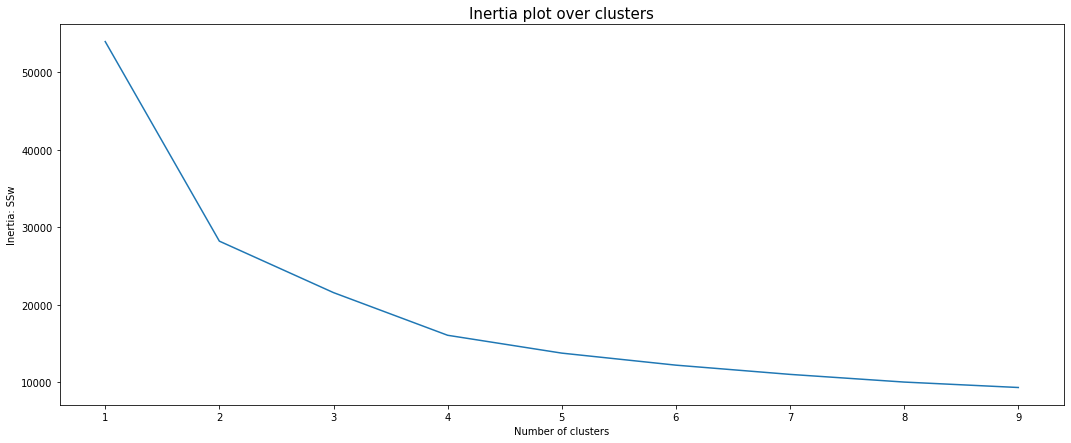

In [123]:
range_clusters = range(1, 10)

inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', random_state=0)
    kmclust.fit(weights_flat)
    inertia.append(kmclust.inertia_)
    
plt.figure(figsize=(18,7))
plt.plot(range_clusters, inertia)
plt.xticks(range_clusters)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)

plt.show()

The optimal cluster amount appears to be k= 4.

## 9. Final Clustering Solution

Finally, we generate the final clustering output.

In [124]:
som_final = MiniSom(
    tuned['x'], tuned['y'], orig_scaled.shape[1],
    sigma=tuned['sigma'], learning_rate=tuned['learning_rate'],
    topology='hexagonal', random_seed=0
)
som_final.random_weights_init(orig_scaled.values)
som_final.train(orig_scaled.values, tuned['num_iterations'])

weights = som_final.get_weights()
weights_flat = weights.reshape((tuned['x']*tuned['y']), -1)

km_final  = KMeans(n_clusters=4, random_state=0)
km_labels = km_final.fit_predict(weights_flat)

bmus         = np.array([som_final.winner(x) for x in orig_scaled.values])
flat_indices = bmus[:,0] * tuned['y'] + bmus[:,1]
sample_lbls  = km_labels[flat_indices]

final_solution = orig_scaled.copy()
final_solution['label'] = sample_lbls

xx, yy = som_final.get_euclidean_coordinates()


## 10. Final Clustering Evaluation Metrics

Here, we compute the metrics used to evaluate the clustering output.

In [125]:
def evaluate_clustering(X, labels, model_name='Model'):
    
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)

    df = pd.DataFrame([{
        'Model':      model_name,
        'Silhouette': sil,
        'DB':         db,
        'CH':         ch
    }]).set_index('Model')

    return df

In [126]:
final_results = evaluate_clustering(orig_scaled.values, final_solution['label'], model_name='SOM+K-Means')
final_results

,Silhouette,DB,CH
Model,,,
SOM+K-Means,0.424289,1.309856,10590.895916


In [144]:
final_results.to_clipboard()

## 11. Plotting the Results

We then plot the SOM grid in a variety of ways to visually inspect the results.

In [128]:
def plot_umatrix(xx, yy,
                 umatrix,
                 cmap,
                 figsize=(20,20),
                 annotate=False
                ):

    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111)

    ax.set_aspect('equal')

    
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cmap(umatrix[i, j]), 
                                 alpha=1)
            ax.add_patch(hexagon)

            if annotate:
                ax.text(xx[(i, j)], wy, int(np.round(umatrix[i, j],2)*100), 
                        ha='center', va='center', 
                        fontsize=figsize[1], 
                        )

    ax.margins(.05)
    ax.axis("off")

    plt.title("UMatrix")

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0)    
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, 
                                orientation='vertical', alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('distance to neighbouring neurons',
                      rotation=270, fontsize=12)
    plt.gcf().add_axes(ax_cb)

    plt.show()

In [129]:
def plot_hitsmatrix(xx, yy,
                    hitsmatrix,
                    cmap=cm.Blues,
                    figsize=(10,10),
                    annotate=True
                   ):
    
    maxhits = hitsmatrix.max()
    fig, ax = plt.subplots(1,1,figsize=figsize)

    ax.set_aspect('equal')

    colornorm = mpl_colors.Normalize(vmin=np.min(hitsmatrix), 
                                     vmax=np.max(hitsmatrix))

    
    for i in range(hitsmatrix.shape[0]):
        for j in range(hitsmatrix.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hits = int(hitsmatrix[i, j])
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.99 / np.sqrt(3),
                                 facecolor=cmap(colornorm(hits)), 
                                 edgecolor=cmap(colornorm(hits)), 
                                 alpha=1, 
                                )
            ax.add_patch(hexagon)
            if annotate & (hits > 0):
                textcolor = 'white' if colornorm(hits) > .65 else 'black'
                annot = str(hits) + " " + str(np.round(colornorm(hits),2))
                ax.text(xx[(i, j)], wy, hits, 
                        ha='center', va='center', 
                        fontsize=figsize[1], 
                        color=textcolor)


    ax.margins(.05)
    ax.axis("off")

    plt.title("Hits Map")


    
    divider = make_axes_locatable(ax)

    ax_cb = divider.new_horizontal(size="2%", pad=0)    

    
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 16

    
    fig.add_axes(ax_cb)
    cb1.ax.set_ylabel('Hits Frequency',
                  rotation=270, fontsize=12)

    plt.show()

In [130]:
def plot_clusters(xx, yy, clusmatrix, k, title="Clusters", annotate=False):
    colors = [plt.cm.Set2(i) for i in range(k)]

    fig, ax = plt.subplots(1,1,figsize=(20,20))

    ax.set_aspect('equal')

    
    for i in range(clusmatrix.shape[0]):
        for j in range(clusmatrix.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=1 / np.sqrt(3),
                                 facecolor=colors[clusmatrix[i][j]], 
                                 alpha=.5, 
                                )
            ax.add_patch(hexagon)
            if annotate:
                ax.text(xx[(i, j)], wy, clusmatrix[i][j], ha='center', va='center', fontsize=8)


    ax.margins(.05)
    ax.axis("off")

    plt.title(title)

    plt.show()

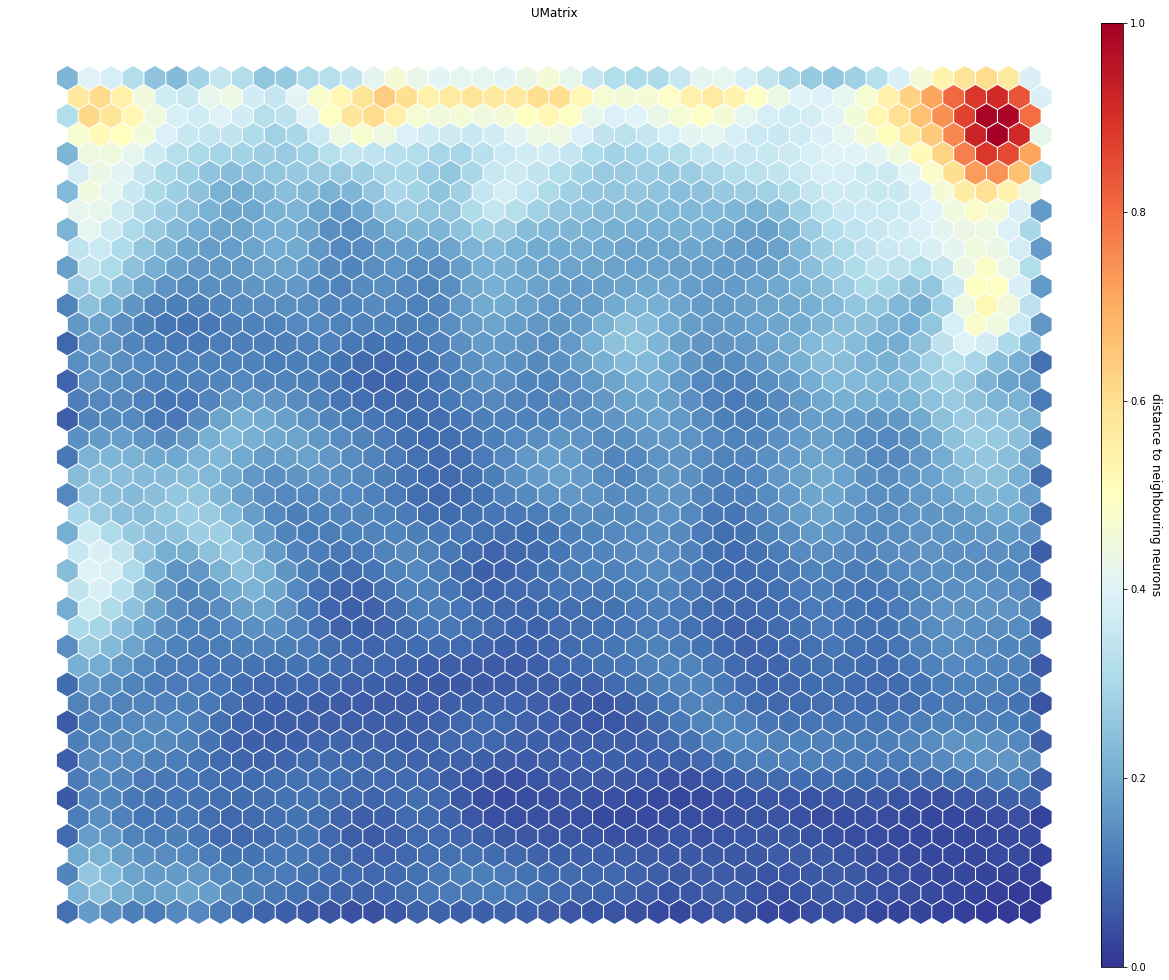

In [131]:
plot_umatrix(xx,yy,umatrix=som_final.distance_map(),cmap=cm.RdYlBu_r, figsize=(20,20))

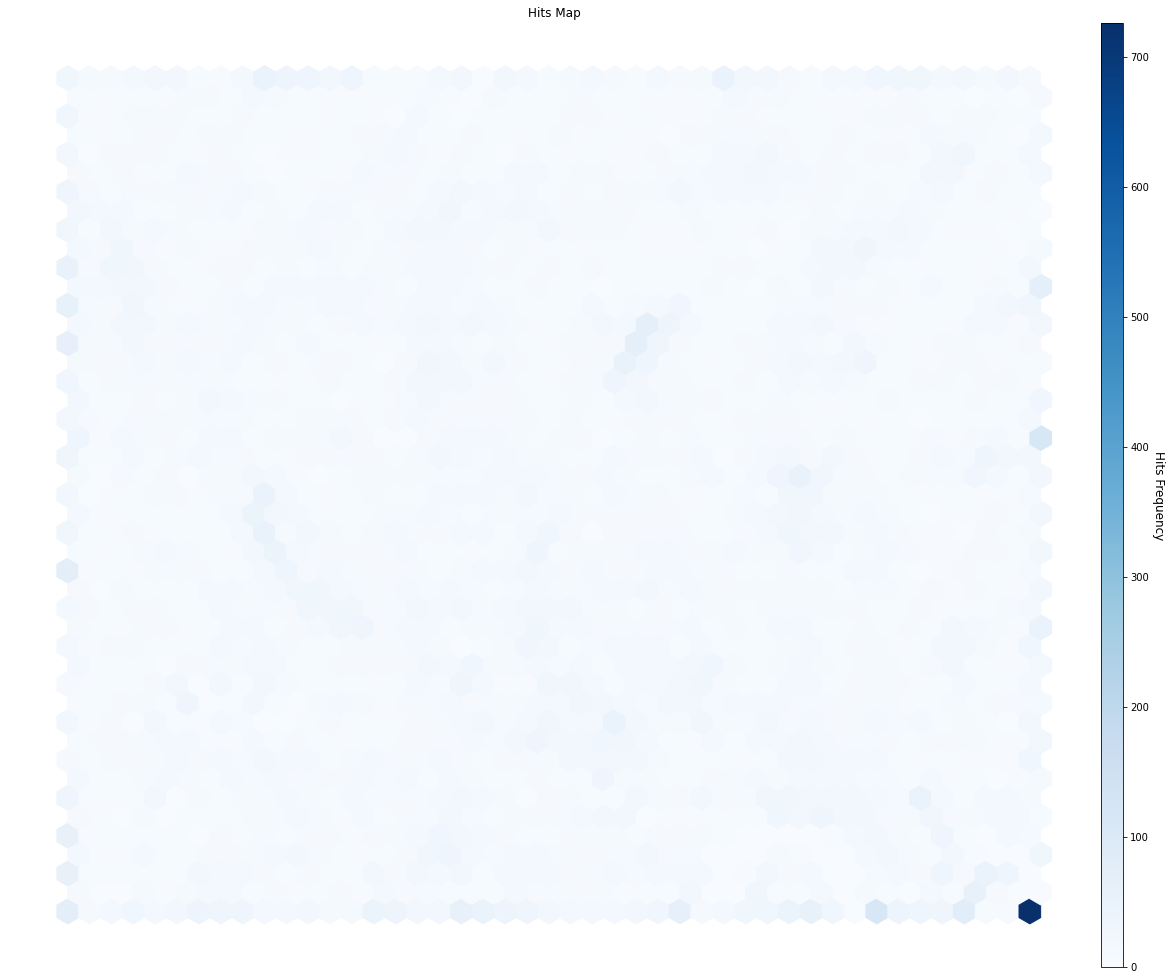

In [132]:
plot_hitsmatrix(xx,yy,hitsmatrix = som_final.activation_response(orig_scaled.values), figsize=(20,20), annotate=False)

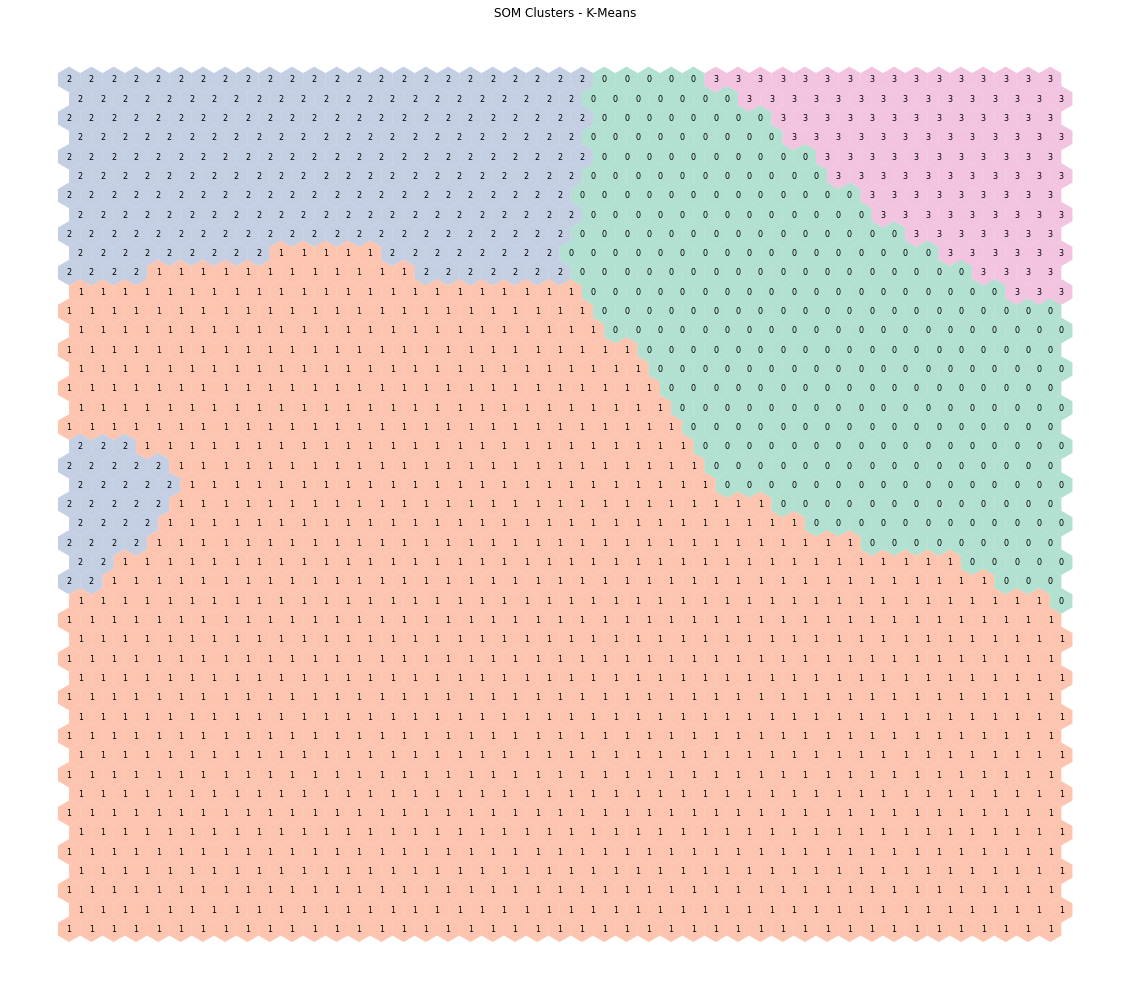

In [133]:
plot_clusters(xx, yy, km_labels.reshape(tuned['x'],tuned['y']), len(set(km_labels)), "SOM Clusters - K-Means", annotate=True)

In [134]:
size_df = pd.DataFrame(final_solution.groupby("label")['label'].count())
size_df.to_clipboard()
size_df

,label
label,
0,4204
1,17370
2,3082
3,1259


In [145]:
size_df.to_clipboard()

## 12. Generating Cluster Means Table for Cluster Analysis

Finally, we generate a dataframe with all the variables averaged by cluster to analyze the cluster characteristics in the theoretical portion of the work.

In [135]:
analysis_df = ratios.copy()
analysis_df['label'] = final_solution['label']

In [136]:
analysis_df.groupby("label").mean()

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ,N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_1_OU_2_PISOS,N_EDIFICIOS_3_OU_MAIS_PISOS,N_EDIFICIOS_CONSTR_ANTES_1945,N_EDIFICIOS_CONSTR_1946_1980,N_EDIFICIOS_CONSTR_1981_2000,N_EDIFICIOS_CONSTR_2001_2010,N_EDIFICIOS_CONSTR_2011_2021,N_EDIFICIOS_COM_NECESSIDADES_REPARACAO,N_ALOJAMENTOS_TOTAL,N_ALOJAMENTOS_FAMILIARES,N_ALOJAMENTOS_FAM_CLASS_RHABITUAL,N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA,N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_COM_ESTACIONAMENTO,N_RHABITUAL_PROP_OCUP,N_RHABITUAL_ARRENDADOS,N_AGREGADOS_DOMESTICOS_PRIVADOS,N_ADP_1_OU_2_PESSOAS,N_ADP_3_OU_MAIS_PESSOAS,N_NUCLEOS_FAMILIARES,N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25,N_INDIVIDUOS,N_INDIVIDUOS_H,N_INDIVIDUOS_M,N_INDIVIDUOS_0_14,N_INDIVIDUOS_15_24,N_INDIVIDUOS_25_64,N_INDIVIDUOS_65_OU_MAIS,N_EDIFICIOS_NAO_EXCLUSIV_RESID,N_EDIFICIOS_SEM_NECESSIDADES_REPARACAO,N_RHABITUAL_NAO_ACESSIVEL_CADEIRAS_RODAS,N_RHABITUAL_SEM_ESTACIONAMENTO,N_RHABITUAL_OCUPADOS_OUTR_SITUACAO
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17.238820,0.149341,0.850659,0.918133,0.147026,0.852974,0.077963,0.470730,0.307131,0.130536,0.013640,0.363596,130.105138,130.036870,0.826697,0.173303,0.216303,0.274529,0.620301,0.315942,106.396051,0.624705,0.375295,72.312559,36.726689,248.156042,0.465132,0.534868,0.141098,0.105284,0.537011,0.216607,0.081867,0.636404,0.783697,0.725471,0.063756
1,12.023086,0.782378,0.217622,0.956388,0.708687,0.291313,0.106988,0.375624,0.325625,0.151102,0.040660,0.339248,22.413587,22.374381,0.732190,0.267810,0.357273,0.580249,0.663389,0.224417,16.947553,0.572823,0.427177,12.480138,6.128785,42.253195,0.484222,0.515778,0.133631,0.110617,0.496883,0.258869,0.043612,0.660752,0.642727,0.419751,0.112194
2,44.861129,0.929146,0.070854,0.992661,0.865741,0.134259,0.095993,0.406682,0.312008,0.141513,0.043804,0.366264,61.028228,60.938352,0.752050,0.247950,0.375694,0.580786,0.666843,0.242951,45.705386,0.573310,0.426690,34.383193,17.059377,115.779364,0.482830,0.517170,0.139476,0.105022,0.511890,0.243612,0.007339,0.633736,0.624306,0.419214,0.090206
3,26.216839,0.104109,0.895891,0.896754,0.101203,0.898797,0.068733,0.380165,0.368264,0.167929,0.014909,0.360079,297.594917,297.492454,0.835902,0.164098,0.349385,0.320379,0.642176,0.294406,246.586180,0.605571,0.394429,169.327244,90.006354,584.741859,0.465434,0.534566,0.147428,0.108968,0.548424,0.195181,0.103246,0.639921,0.650615,0.679621,0.063418


In [146]:
analysis_df.groupby("label").mean().to_clipboard()